<a href="https://colab.research.google.com/github/ShinyRyo/TPU/blob/master/PyTorch_on_Cloud_TPUs_Single_Core_Training_AlexNet_on_Fashion_MNIST_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##PyTorch on Cloud TPUs: Single Core Training AlexNet on Fashion MNIST 

This notebook trains the [AlexNet](https://arxiv.org/abs/1404.5997) network on the [Fashion MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) using PyTorch with a single Cloud TPU core. This will show you how to train your own networks on a single Cloud TPU core and highlight the differences between using one vs. many Cloud TPU cores.

PyTorch can use Cloud TPU cores as devices with the PyTorch/XLA package. For more on PyTorch/XLA see its [Github](https://github.com/pytorch/xla) or its [documentation](http://pytorch.org/xla/). We also have a ["Getting Started"](https://colab.research.google.com/github/pytorch/xla/blob/master/contrib/colab/getting-started.ipynb) Colab notebook. Additional Colab notebooks, like this one, are available on the PyTorch/XLA Github.







### Installing PyTorch/XLA

Run the following cell (or copy it into your own notebook!) to install PyTorch, Torchvision, and PyTorch/XLA. It will take a couple minutes to run.

In [0]:
VERSION = "20200325"  #@param ["1.5" , "20200325", "nightly"]
!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
!python pytorch-xla-env-setup.py --version $VERSION

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4264  100  4264    0     0  59222      0 --:--:-- --:--:-- --:--:-- 59222
Updating TPU and VM. This may take around 2 minutes.
Updating TPU runtime to pytorch-dev20200325 ...
Uninstalling torch-1.5.0+cu101:
Done updating TPU runtime: <Response [200]>
  Successfully uninstalled torch-1.5.0+cu101
Uninstalling torchvision-0.6.0+cu101:
  Successfully uninstalled torchvision-0.6.0+cu101
Copying gs://tpu-pytorch/wheels/torch-nightly+20200325-cp36-cp36m-linux_x86_64.whl...
- [1 files][ 83.4 MiB/ 83.4 MiB]                                                
Operation completed over 1 objects/83.4 MiB.                                     
Copying gs://tpu-pytorch/wheels/torch_xla-nightly+20200325-cp36-cp36m-linux_x86_64.whl...
\ [1 files][114.5 MiB/114.5 MiB]                                                
Operation completed over 1 objec

### Dataset & Network

In this notebook we'll train AlexNet on the Fashion MNIST dataset. Both are provided by the [Torchvision package](https://pytorch.org/docs/stable/torchvision/index.html).

Before diving in, let's look at the Fashion MNIST dataset. The dataset has 10 classes, each represented by an integer index. The following cell creates a mapping from these indices to their corresponding human-readable strings, then downloads the Fashion MNIST training dataset from Torchvision. It may take a minute to run.

Torchvision provides easy access to many datasets, including COCO, CIFAR, and Cityscapes. See its documentation for a complete list. 

The dataset is stored on the Colab VM in the `/tmp/fashionmnist` directory.



In [0]:
# Downloads the Fashion MNIST dataset using Torchvision
# Note: This may take a minute.
import os
import torch
import torchvision
import torchvision.datasets as datasets

# Maps integer class index to human-readable string describing the class
class_map = {
0 : "t-shirt",
1 : "trouser",
2 : "pullover",
3 : "dress",
4 : "coat",
5 : "sandal",
6 : "shirt",
7 : "sneaker",
8 : "bag",
9 : "ankle boot"
}

# Downloads the Fashion MNIST dataset using Torchvision
raw_dataset = datasets.FashionMNIST(
  os.path.join("/tmp/fashionmnist"),
  train=True,
  download=True)

Extracting /tmp/fashionmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to /tmp/fashionmnist/FashionMNIST/raw


Extracting /tmp/fashionmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /tmp/fashionmnist/FashionMNIST/raw


Extracting /tmp/fashionmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /tmp/fashionmnist/FashionMNIST/raw


Extracting /tmp/fashionmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /tmp/fashionmnist/FashionMNIST/raw
Processing...


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.




Done!


Now that we have the dataset, we can look at elements of it directly. Each element of raw_dataset is a tuple. The first element is a single channel greyscale 28x28 Python Image Library (PIL) image, and the second element is the example's class index. You can change the `img_index` in the following cell to visualize different examples.

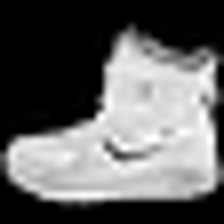

ankle boot


In [0]:
img_index = 0
tup = raw_dataset[img_index]
display(tup[0].resize((224, 224)))
print(class_map[tup[1]])

Now we'll create our AlexNet model and put it on a Cloud TPU core.

Torchvision lets us download many model architectures, including VGG, ResNet, and MobileNet. See its documentation for a complete list. 

In [0]:
import torch_xla
import torch_xla.core.xla_model as xm


# Creates AlexNet for 10 classes
net = torchvision.models.alexnet(num_classes=10)

# Acquires the default Cloud TPU core and moves the model to it
device = xm.xla_device()
net = net.to(device)

### Dataloaders

Now that we have our dataset and network, let's look at how we'll transform and load the data. As we saw when looking at the Fashion MNIST dataset (above), the examples are 28x28 single channel greyscale PIL images. Torchvision networks, however, expect PyTorch tensors representing  normalized three channel RGB images that are at least 224x224. The following cell defines a conversion from the original examples to the PyTorch tensors our AlexNet requires.


In [0]:
import torchvision.transforms as transforms

# See https://pytorch.org/docs/stable/torchvision/models.html for normalization
# Pre-trained TorchVision models expect RGB (3 x H x W) images
# H and W should be >= 224
# Loaded into [0, 1] and normalized as follows:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
to_rgb = transforms.Lambda(lambda image: image.convert('RGB'))
resize = transforms.Resize((224, 224))
my_transform = transforms.Compose([resize, to_rgb, transforms.ToTensor(), normalize])

Now we can download train and test datasets using TorchVision and apply this transform to them.

In [0]:
train_dataset = datasets.FashionMNIST(
  os.path.join("/tmp/fashionmnist"),
  train=True,
  download=True,
  transform=my_transform)

test_dataset = datasets.FashionMNIST(
  os.path.join("/tmp/fashionmnist"),
  train=False,
  download=True,
  transform=my_transform)

PyTorch provides a variety of "Samplers" to acquire elements of datasets in different orders. The [Random Sampler](https://pytorch.org/docs/stable/data.html#torch.utils.data.RandomSampler), which we'll use, samples elements randomly without replacement.

In [0]:
train_sampler = torch.utils.data.RandomSampler(train_dataset)
test_sampler = torch.utils.data.RandomSampler(test_dataset)

Finally, we create DataLoaders that load batches of examples from our Dataset according to our Sampler's policy. 

In [0]:
batch_size = 8

train_loader = torch.utils.data.DataLoader(
  train_dataset,
  batch_size=batch_size,
  sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
  test_dataset,
  batch_size=batch_size,
  sampler=test_sampler)

### Evaluating the Network

Before training we want to verify our data->network pipeline and set a baseline level of performance. The following cell defines a function, `eval_network,` that runs a network on a dataset and shows the percentage of the dataset that was correctly classified as well as a sample batch.

In [0]:
import time
from google.colab import widgets

t_to_img = transforms.Compose([transforms.ToPILImage(), transforms.Grayscale()])

# Runs the given net on the batches provided by the test_loader
# Records the number of correct predictions (guesses) and 
# prints the percentage of correct guesses on the dataset, plus a 
# sample batch.
def eval_network(net, test_loader):
  start_time = time.time()
  num_correct = 0
  total_guesses = 0

  # Sets eval and no grad context for evaluation
  net.eval()
  with torch.no_grad():
    for data, targets in iter(test_loader):
      # Sends data and targets to device
      data = data.to(device)
      targets = targets.to(device)

      # Acquires the network's best guesses at each class
      results = net(data)
      best_guesses = torch.argmax(results, 1)

      # Updates number of correct and total guesses
      num_correct += torch.eq(targets, best_guesses).sum().item()
      total_guesses += batch_size
    
    # Prints output
    elapsed_time = time.time() - start_time
    print("Correctly guessed ", num_correct/total_guesses*100, "% of the dataset")
    print("Evaluated in ", elapsed_time, " seconds")
    print("Sample batch:")
    
    # Uses last batch as sample
    grid = widgets.Grid(2, 4)
    row = 0
    col = 0
    for ex in zip(data, targets, best_guesses):
      data = ex[0].cpu()
      target = class_map[ex[1].item()]
      guess = class_map[ex[2].item()]

      img = t_to_img(data)

      with grid.output_to(row, col):
        display(img)
        print("Target: ", target)
        print("Guess: ", guess)

        # Updates grid location
        if col == 3:
          row += 1
          col = 0
        else:
          col += 1

Correctly guessed  10.0 % of the dataset
Evaluated in  95.29976677894592  seconds
Sample batch:


,,,
,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

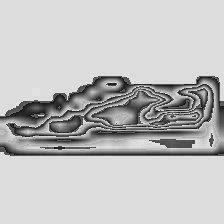

Target:  sneaker
Guess:  bag


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

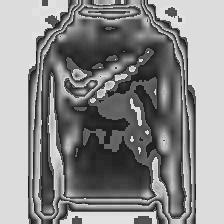

Target:  pullover
Guess:  bag


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

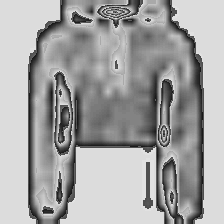

Target:  pullover
Guess:  bag


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

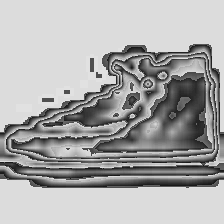

Target:  ankle boot
Guess:  bag


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

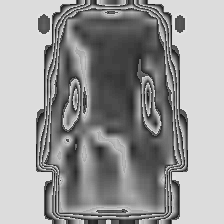

Target:  dress
Guess:  bag


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

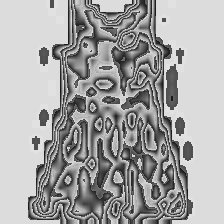

Target:  dress
Guess:  bag


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

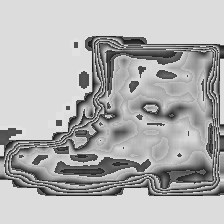

Target:  ankle boot
Guess:  bag


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

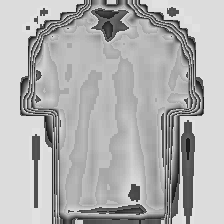

Target:  t-shirt
Guess:  bag


<IPython.core.display.Javascript object>

In [0]:
# Percentage of guesses that are correct (expected to be 0.1)
eval_network(net, test_loader)

You should see the untrained network guess about 10% of the dataset correctly, since it's randomly guessing and there are 10 classes.

### Training the Network

Randomly guessing at what we're seeing isn't very interesting, so it's time to train our network.

Basic training in PyTorch:

- enumerates a dataset in batches
- runs the network on each batch
- evaluates the network's performance using a loss function
- calls `backward()` to propagate gradients through the network
- uses an optimizer to `step()` and apply the gradients to the network's weights

In this case we'll use the [CrossEntropyLoss](https://pytorch.org/docs/master/nn.html#torch.nn.CrossEntropyLoss) since we have a classification problem and AlexNet returns unnormalized scores for each class. We'll also use the [Adam](https://pytorch.org/docs/master/optim.html#torch.optim.Adam) optimizer since it's a popular optimizer.

We'll only train for a single epoch for timeliness. The following cell should take 4-5 minutes to run.

In [0]:
# Note: this will take 4-5 minutes to run.
num_epochs = 1
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters())

# Ensures network is in train mode
net.train()

start_time = time.time()
for epoch in range(num_epochs):
  for data, targets in iter(train_loader):
    # Sends data and targets to device
    data = data.to(device)
    targets = targets.to(device)

    # Acquires the network's best guesses at each class
    results = net(data)

    # Computes loss
    loss = loss_fn(results, targets)

    # Updates model
    optimizer.zero_grad()
    loss.backward()
    xm.optimizer_step(optimizer, barrier=True)  # Note: Cloud TPU-specific code!

elapsed_time = time.time() - start_time
print ("Spent ", elapsed_time, " seconds training for ", num_epochs, " epoch(s) on a single core.")

Spent  561.9278566837311  seconds training for  1  epoch(s) on a single core.



So far we've just used Cloud TPU cores as devices, like any other PyTorch device. In the above training loop we see our first Cloud TPU-specific line of code: `xm.optimizer_step(optimizer, barrier=True).` 

PyTorch uses Cloud TPUs through the [XLA deep learning compiler](https://www.tensorflow.org/xla). This compiler records the operations we perform into a graph which is evaluated all-at-once and as needed. `xm.optimizer_step(optimizer, barrier=True)` inserts a "barrier" in the graph that forces evaluation every time the gradients are updated. This prevents XLA's graphs from growing too large. For more details about how PyTorch uses XLA and Cloud TPUs see [the documentation](http://pytorch.org/xla/).


We can now re-evaluate our network's performance:

Correctly guessed  10.0 % of the dataset
Evaluated in  100.05671286582947  seconds
Sample batch:


,,,
,,,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

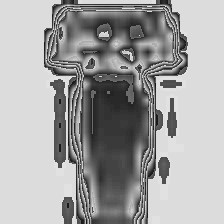

Target:  dress
Guess:  dress


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

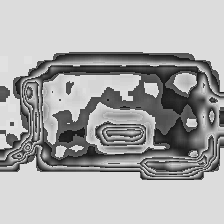

Target:  bag
Guess:  dress


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

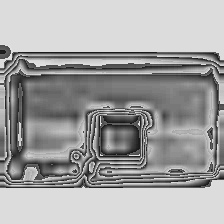

Target:  bag
Guess:  dress


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

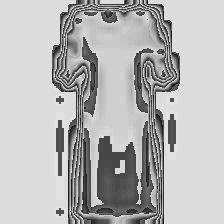

Target:  dress
Guess:  dress


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

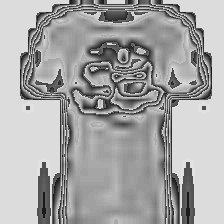

Target:  t-shirt
Guess:  dress


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

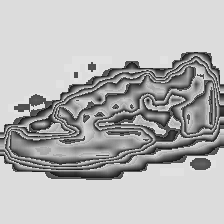

Target:  sneaker
Guess:  dress


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

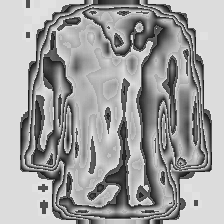

Target:  shirt
Guess:  dress


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

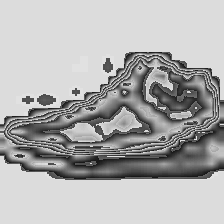

Target:  sneaker
Guess:  dress


<IPython.core.display.Javascript object>

In [0]:
eval_network(net, test_loader)

You should see the network dramatically improve (it should guess 60%+).

### What's Next

This Colab showed how to train AlexNet on the Fashion MNIST dataset using a single Cloud TPU core. Using a Cloud TPU core as a device required one tweak to our network: instead of calling `optimizer.step()` we called `optimizer_step(optimizer, barrier=True).` In future Colabs we'll see a few other tweaks that will let us maximize PyTorch's performance on Cloud TPUs. The [documentation](http://pytorch.org/xla/) also describes them. 

Additional information about PyTorch on Cloud TPUs, including more sample Colabs, is available on the PyTorch/XLA package's [Github](https://github.com/pytorch/xla). You're encouraged to try PyTorch on Cloud TPUs on both Colab and Google Cloud Platform, too! For Colab, just copy the first code cell in this notebook to start your own. If you have ideas/suggestions/comments the best way to contact the team is with an [issue on our Github](https://github.com/pytorch/xla/issues). 